<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg"
WIDTH=200 HEIGHT=200>

<CENTER>
</br>
<p><font size="5"> TAF MCE - 2019</span></p>
<p><font size="4">  UE Stochastic dynamic systems </font></p>
<p></p>
<p><font size="5">  Notebook 02: Julia lab - Stochastic differential equations </font></p>
</p></br>
</p>
</CENTER>

----------

# <span style="color:#00B8DE">I - Simulation of SDEs (lab 4)</span>

1 - Define a function **Gauss(m=0,v=1)** that returns a function that takes an argument $x$ and returns the value $\mathcal{N}(x;m,v)$.

2 - Define a structure named **Brownian** with the following fields: 

    Δ     # sampling stepsize
    Tmin  # initial time
    Tmax  # final time
    B0    # initial value
    σ2    # variance
Add methods **sample** and **draw** that respectively sample the Brownian motion and plots a given number of trajectories. Design also a method **hist** that plots the histogram of the Brownian motion at a given time $t$ in $[Tmin,Tmax]$ and for a given number of realizations.

3 - Run the code and check that the results are coherent.

4 - We consider the Black-Scholes equation
$$
dX_t = rX_tdt + aX_tdB_t
$$
with $r=-1$ and $a=1$. Recall the analytic solution for this equation and plot it over
$[0,1]$for realizations of $B_t$ sampled at 1000 points.

5 - Implement Euler, Millstein and Runge-Kutta with order 1.5 methods. Possibly, create a **model** structure with fields drift, diffusion and the derivative of diffusion so that the integration method can apply automatically from model and Brownian trajectory specification. 
Plot the solutions corresponding solutions and compute the mean squared error. Possibly different sampling stepsize could be considered. Conclusions ?

In [22]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
import random as rd

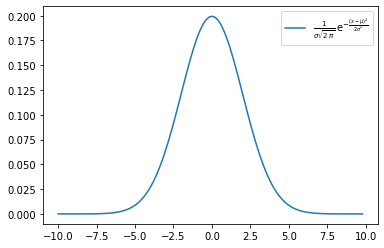

In [23]:
# 1

def gauss(x,mu=0,sig=1):
    return np.exp( -(x-mu)**2/(2*sig**2) ) / ( sig*np.sqrt(2*np.pi) )

# test

# Defining the constants
m = 10
length = 100

# Ploting the result
X = np.arange(-m,m,2*m/length)
f = [gauss(x, sig=2) for x in X]
plt.plot(X,f,label=r"${\frac {1}{\sigma {\sqrt {2\,\pi }}}}\,\mathrm {e} ^{-{\frac {\left(x-\mu \right)^{2}}{2\sigma ^{2}}}}}$")
plt.legend()
plt.show()

In [24]:
# 2

class Brownian:
    def __init__(self, delta=0.1, Tmin=0., Tmax=1., B0=0., sig2=1.):
        self.delta = delta
        self.Tmin = Tmin
        self.Tmax = Tmax
        self.B0 = B0
        self.sig2 = sig2
        self.t_values = np.arange(Tmin, Tmax, delta)
    
    def sample(self):
        # Initialization of the Brownian motion
        B = [self.B0]
        # Calculation of the number of sampling steps
        n = int((self.Tmax - self.Tmin)/self.delta)
        # Sampling loop
        for i in range(n-1):
            # B[i+1] = B[i] + sqrt(delta)*random_variable
            B.append(B[i] + np.sqrt(self.delta)*np.random.normal(0, 1))
        return B
    
    def samples(self, n=100):
        return np.array([self.sample() for _ in range(n)])
    
    def get_envelope(self,B):
        mean_path = np.mean(B, axis=0)
        std_dev = np.std(B, axis=0)
        upper_bound = mean_path + 3 * std_dev
        lower_bound = mean_path - 3 * std_dev
        return upper_bound, lower_bound

    
    def draw(self, n_trajectories=100, enveloppe=True):
        B = self.samples(n_trajectories)
        plt.figure(figsize=(10, 6))
        for i in range(n_trajectories):
            plt.plot(self.t_values, B[i,:])
        if enveloppe:
            upper_bound, lower_bound = self.get_envelope(B)
            plt.fill_between(self.t_values, upper_bound, lower_bound, color='gray', alpha=0.3, label='Enveloppe')
        plt.xlabel('Time')
        plt.ylabel('Brownian Motion')
        plt.title(f'{n_trajectories} Brownian Motion Trajectories')
        plt.show()
    
    def hist(self, t=0.5, n_realizations=1000, theoric= True):
        B = self.samples(n_realizations)
        t_index = int((t - self.Tmin) / self.delta)
        plt.hist(B[:, t_index], bins=20, density=True, alpha=0.6, color='b', label='Histogram')
        
        # Overlay the theoretical density function
        mu_t = self.B0
        sigma_t = np.sqrt(self.sig2 * t)
        x = np.linspace(mu_t - 3*sigma_t, mu_t + 3*sigma_t, 100)
        pdf = (1/(np.sqrt(2*np.pi)*sigma_t)) * np.exp(-(x - mu_t)**2 / (2*sigma_t**2))
        if theoric :
            plt.plot(x, pdf, color='r', label='Theoretical distribution')
        
        plt.xlabel('Value')
        plt.ylabel('Probability Density')
        plt.title(f'Histogram at t={t}')
        plt.legend()
        plt.show()


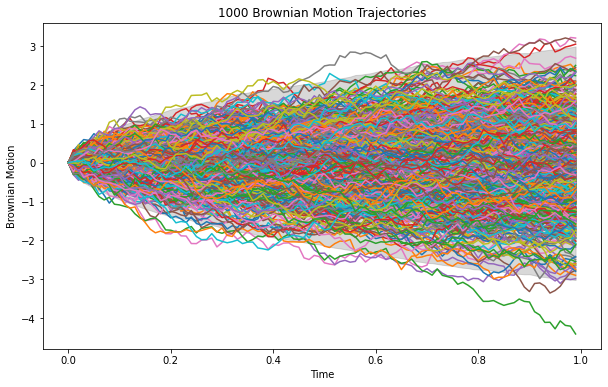

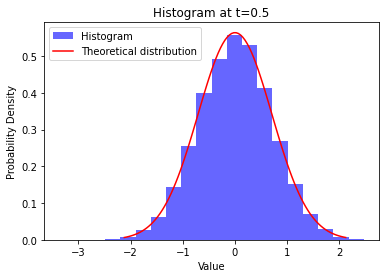

In [25]:
# 3
        
# Create an instance of Brownian
Bro = Brownian(delta=0.01, Tmin=0, Tmax=1, B0=0, sig2=1)

# Draw trajectories with the enveloppe
Bro.draw(10**3)

# Plot histogram
Bro.hist(t=0.5, n_realizations=10**4)

The results shown are coehrent with what was expected. The Brownian model seems to work.

In [26]:
# 4

The Black-Scholes equation you provided is a stochastic differential equation (SDE) that describes the evolution of a stock price under the assumption of constant interest rate $r$ and constant volatility $a$. The analytic solution to this SDE is given by:

$$
X_t = X_0 \exp\left((r - \frac{1}{2}a^2)t + aB_t\right)
$$

Given $r = -1$ and $a = 1$, and assuming an initial value $X_0 = 1$, we can plot the solution over the interval $[0,1]$ using Python: 

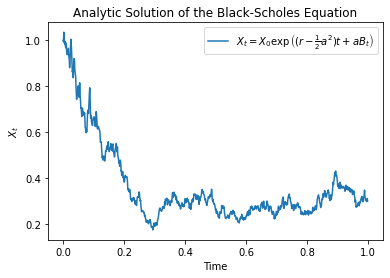

In [27]:
# Black-Scholes model

def black_scholes_trajectory(T=1, X0=1, r=-1, a=1, n_points=1000):
    # Generate Brownian motion
    Brownian_motion = Brownian(delta=T/n_points, Tmin=0, Tmax=T, B0=0, sig2=1)
    dB = Brownian_motion.sample()
    # Compute X_t using the analytic solution
    X_t = X0 * np.exp((r - 0.5*a**2) * Brownian_motion.t_values + a * dB)
    return Brownian_motion.t_values, X_t 

t_values, Xt = black_scholes_trajectory()

# Plot the solution
plt.plot(t_values, Xt, label= r'$X_t = X_0 \exp\left((r - \frac{1}{2}a^2)t + aB_t\right)$')
plt.xlabel('Time')
plt.ylabel(r'$X_t$')
plt.title('Analytic Solution of the Black-Scholes Equation')
plt.legend()
plt.show()


In this code, we first define the parameters $r$, $a$, $X_0$, $T$ (final time), and $n_{\text{points}}$ (number of points for discretization). We then generate a discretized Brownian motion ($dB$) using numpy's random module. Finally, we compute $X_t$ using the analytic solution and plot it over time. The result will be a plot showing the evolution of $X_t$ over the interval $[0,1]$.

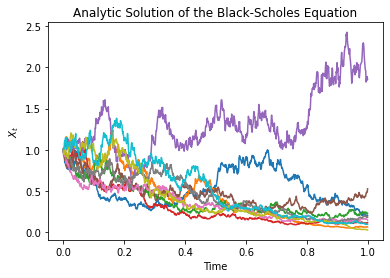

In [28]:
# test 

for _ in range(10):
    t_values, Xt = black_scholes_trajectory()
    plt.plot(t_values, Xt)
plt.xlabel('Time')
plt.ylabel(r'$X_t$')
plt.title('Analytic Solution of the Black-Scholes Equation')
plt.show()

As we can see, due to the use of Brownian motion, the result of this equation is random with the same behavior.

In [34]:
# 5

class Model:
    def __init__(self, drift, diffusion, d_diffusion):
        self.drift = drift
        self.diffusion = diffusion
        self.d_diffusion = d_diffusion

def euler(model, X0, T, delta_t, B):
    num_points = len(B)
    X = np.zeros(num_points+1)
    X[0] = X0
    
    for i in range(num_points-1):
        X[i+1] = X[i] + model.drift(X[i]) * delta_t + model.diffusion(X[i]) * (B[i+1] - B[i])
        
    return X

def milstein(model, X0, T, delta_t, B):
    num_points = len(B)
    X = np.zeros(num_points+1)
    X[0] = X0
    
    for i in range(num_points-1):
        X[i+1] = X[i] + model.drift(X[i]) * delta_t + model.diffusion(X[i]) * (B[i+1] - B[i]) + \
                 0.5 * model.d_diffusion(X[i]) * (B[i+1] - B[i])**2
        
    return X

def runge_kutta(model, X0, T, delta_t, B):
    num_points = len(B)
    X = np.zeros(num_points+1)
    X[0] = X0
    
    for i in range(num_points-1):
        k1 = model.drift(X[i]) * delta_t + model.diffusion(X[i]) * (B[i+1] - B[i])
        k2 = model.drift(X[i] + 0.5*k1) * delta_t + model.diffusion(X[i] + 0.5*k1) * (B[i+1] - B[i])
        k3 = model.drift(X[i] + 0.5*k2) * delta_t + model.diffusion(X[i] + 0.5*k2) * (B[i+1] - B[i])
        k4 = model.drift(X[i] + k3) * delta_t + model.diffusion(X[i] + k3) * (B[i+1] - B[i])
        
        X[i+1] = X[i] + (k1 + 2*k2 + 2*k3 + k4) / 6
        
    return X

# Define Black-Scholes model functions
def drift(X, r=-1):
    return r * X

def diffusion(X, a=1):
    return a * X

def d_diffusion(X,a=1):
    return a

# Define the function to integrate over the equations
def get_integration(functions=(drift, diffusion, d_diffusion), r=-1, a=1, T=1, X0=1, num_points=1000, plotting=True):
    # Create a Model instance
    drift, diffusion, d_diffusion = functions
    bs_model = Model(drift, diffusion, d_diffusion)

    # Generate time points and Brownian motion
    delta_t = T / num_points
    t_values = np.linspace(0, T, num_points+1)
    B = np.cumsum(np.sqrt(delta_t) * np.random.normal(0, 1, num_points))

    # Apply integration methods
    X_euler = euler(bs_model, X0, T, delta_t, B)
    X_milstein = milstein(bs_model, X0, T, delta_t, B)
    X_rk = runge_kutta(bs_model, X0, T, delta_t, B)

    if plotting: 
        # Plot solutions
        plt.figure(figsize=(10, 6))
        plt.plot(t_values, X_euler, label='Euler')
        plt.plot(t_values, X_milstein, label='Milstein')
        plt.plot(t_values, X_rk, label='Runge-Kutta')
        plt.xlabel('Time (t)')
        plt.ylabel('X(t)')
        plt.title('Solutions of the Black-Scholes Equation')
        plt.legend()
        plt.show()

    # Compute Mean Squared Error (MSE)
    true_solution = X0 * np.exp(0.5 * t_values[:-1] + B)
    mse_euler = np.mean((X_euler[:-1] - true_solution)**2)
    mse_milstein = np.mean((X_milstein[:-1] - true_solution)**2)
    mse_rk = np.mean((X_rk[:-1] - true_solution)**2)
    
    if plotting:
        print(f'MSE for Euler method: {mse_euler}')
        print(f'MSE for Milstein method: {mse_milstein}')
        print(f'MSE for Runge-Kutta method: {mse_rk}')
    
    return mse_euler, mse_milstein, mse_rk


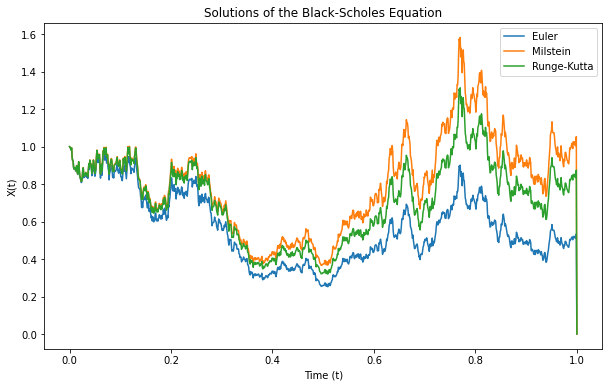

MSE for Euler method: 2.3110409054618564
MSE for Milstein method: 1.512527702258419
MSE for Runge-Kutta method: 1.7902068535912716


(2.3110409054618564, 1.512527702258419, 1.7902068535912716)

In [36]:
get_integration()

Let's compute the MSE for many computation.

In [37]:
# Initializing parameters
n_test = 20
MSE_Euler, MSE_Milstein, MSE_RK = 0, 0, 0

# Computing the integration
for _ in range(n_test):
    res = get_integration(plotting=False)
    MSE_Euler += res[0]
    MSE_Milstein += res[1]
    MSE_RK += res[2]

MSE_Euler /= n_test
MSE_Milstein /= n_test
MSE_RK /= n_test

# plotting results
print(f'With a mean computed on {n_test} we have :')
print(f'MSE for Euler method: {MSE_Euler}')
print(f'MSE for Milstein method: {MSE_Milstein}')
print(f'MSE for Runge-Kutta method: {MSE_RK}')

With a mean computed on 20 we have :
MSE for Euler method: 4.0837024807599445
MSE for Milstein method: 3.3029823361649386
MSE for Runge-Kutta method: 3.158312197842195


Let's consider different step sizes.

Solution of the equation for 10 points:


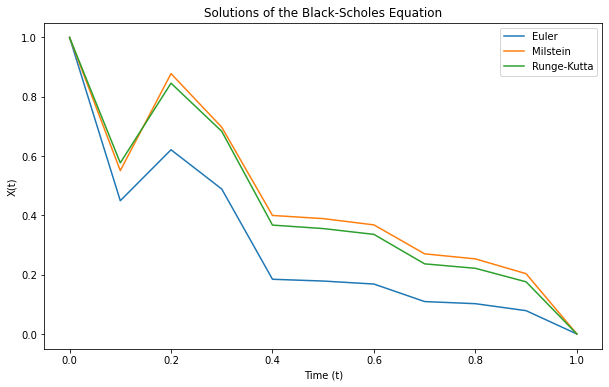

MSE for Euler method: 0.09248297159811555
MSE for Milstein method: 0.03362014161356835
MSE for Runge-Kutta method: 0.04077506590548029


Solution of the equation for 100 points:


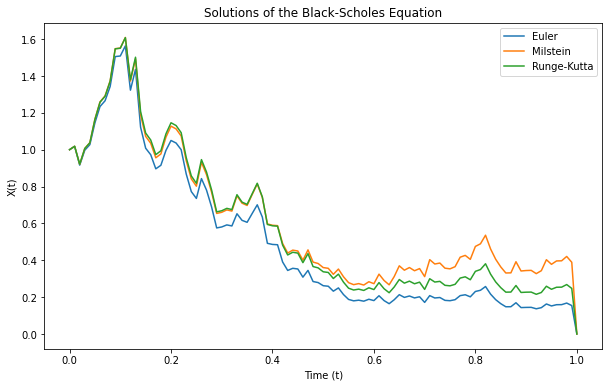

MSE for Euler method: 0.31030982971684307
MSE for Milstein method: 0.17808886766693088
MSE for Runge-Kutta method: 0.2281136822146432


Solution of the equation for 1000 points:


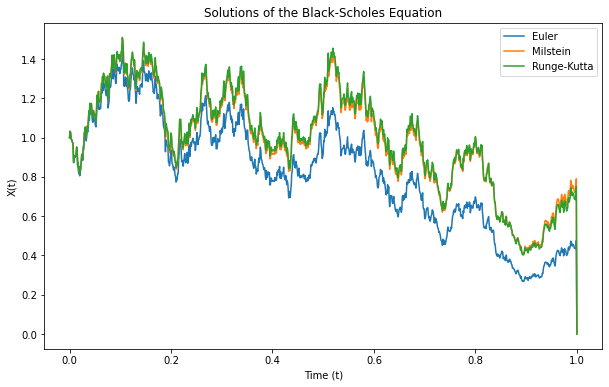

MSE for Euler method: 2.130125671138942
MSE for Milstein method: 1.6384309312411922
MSE for Runge-Kutta method: 1.6189402276274445


Solution of the equation for 10000 points:


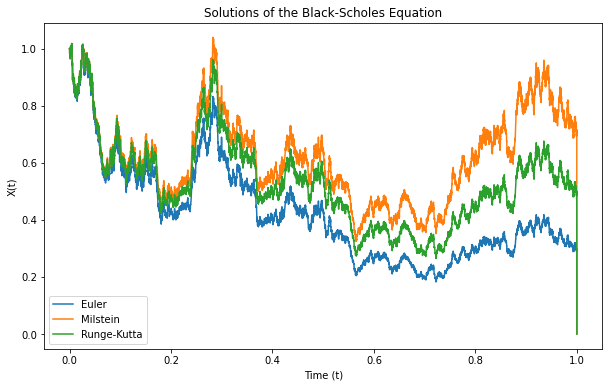

MSE for Euler method: 0.9248006813818181
MSE for Milstein method: 0.525367112995774
MSE for Runge-Kutta method: 0.7111134271049611


Solution of the equation for 10000 points:


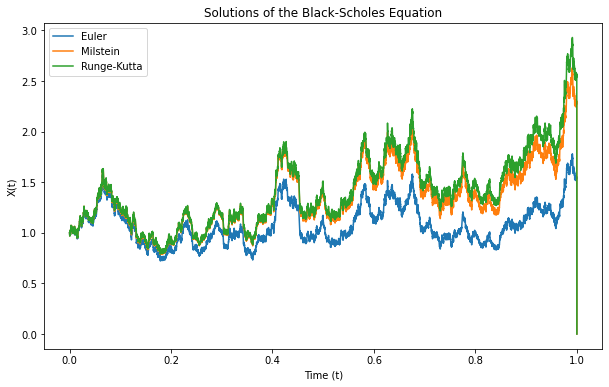

MSE for Euler method: 11.867658443100169
MSE for Milstein method: 9.766955774110931
MSE for Runge-Kutta method: 9.234413020115282


Solution of the equation for 100000 points:


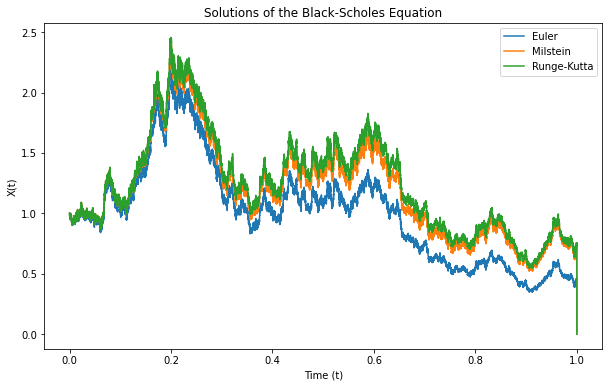

MSE for Euler method: 3.42814970027637
MSE for Milstein method: 2.729170245281435
MSE for Runge-Kutta method: 2.5475957986249185




In [38]:
n_pts=[10, 10**2, 10**3, 10**4, 10**4, 10**5]
euler_err, mislten_error, rk_error = [], [], []

for pts in n_pts:
    print(f"Solution of the equation for {pts} points:")
    res = get_integration(num_points=pts)
    euler_err.append(res[0])
    mislten_error.append(res[1])
    rk_error.append(res[2])
    print("\n")

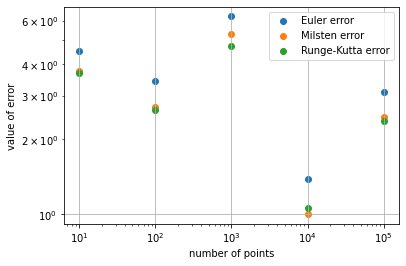

In [39]:
n_pts=[10, 10**2, 10**3, 10**4, 10**5]
n_test = 20
e_er, m_er, rk_er = 0, 0, 0
euler_err, mislten_error, rk_error = [], [], []

for pts in n_pts:
    for _ in range(n_test):
        res = get_integration(num_points=pts, plotting=False)
        e_er += res[0]
        m_er += res[1]
        rk_er += res[2]
    e_er /= n_test
    m_er /= n_test
    rk_er /= n_test
    euler_err.append(e_er)
    mislten_error.append(m_er)
    rk_error.append(rk_er)
    e_er, m_er, rk_er = 0, 0, 0
    

plt.scatter(n_pts, euler_err, label='Euler error')
plt.scatter(n_pts, mislten_error, label='Milsten error')
plt.scatter(n_pts, rk_error, label='Runge-Kutta error')
plt.xlabel("number of points")
plt.ylabel("value of error")
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

We would expect that the increase of point would decrease the MSE but it's not the case, it's mainly random because of the noise. So the number of points is not that relevant.

-------

# <span style="color:#00B8DE">II - Parameter estimation for SDEs (lab 5&6)</span>

Let us consider the following SDE:
$$
dX_t=b(X_t)dt+\theta\sigma(X_t)dB_t\quad (1)
$$
a regularly sampled trajectory of which is observed at instants $t_i$. let $X_i=X_{t_i}$ ($i=1,\ldots,n$) 
denote observation variables $x_i,…,x_n$ corresponding observations. We shall assume that functions $b(x)$ and
$\sigma(x)$ are known but that $\theta$ is unknown 
 and changes at a given, instant that we want to estimate.

1 - Denoting by $\Delta$ the sampling period, supply the discretized version of (1) for Euler sampling method.

2 - We define the normalized increments as
$$
Z_i=\theta \dfrac{B_{i+1}−B_i}{\sqrt \Delta}\quad (2)
$$
Express $Z_i$ in terms of observation variables  Xi and give their distribution.

3 - Let $k$ denote the index value in $\{2,\ldots,n−1\}$ from which the value of $\theta$ 
changes. Let $\theta_1$ denote the value taken by $\theta$ until the time $\tau$ corresponding to $k$
and $\theta_2$ the value it takes after this instant. Compute maximum likelihood estimators of $\theta_1^2$ and $\theta_2^2$ as a function of $\tau$.

4 - Then check that the maximum likelihood estimator of the position $k$ of system transition is given by 
$\hat{k}=\arg\min_k D_k$, with
$$
D_k=k\log\dfrac{S_k}{k}+(n−k)\log\dfrac{S_n−S_k}{n−k}\quad (3)
$$
and $S_k=\sum^k_{i=1}Z^2_i$.

5 - As an example, we consider the Cox-Ingersoll-Ross processus with equation
$$
dX_t=(a−bX_t)dt+θ\sqrt{X_t}dBt \quad (4)
$$
This model has been used first to model population growth. The solution is given by
$$
X_t=X_0+\dfrac a b (1−e^{−bt})+\theta\int_0^te^{b(u−t)}\sqrt{X_u}dB_u\quad (5)
$$
6 - Let $(a,b)=(5,2)$, $\tau=0.6$ and $(\theta_1,\theta_2)=(1,3)$. 
Plot a few trajectories of the process over $[0,1]$ with for instance $X_0=4$. 
To this end, you can discretize the solution (5) directly with a stepsize $\Delta=10^{−2}$.

7 - Plot the evolution of the decision variable $D_k$ with $k$ for several simulated  trajectories.

8 - Estimate $\tau$ and $(\theta_1,\theta_2)$ for these trajectories and plot the sequence of values obtained.

9 - Still assuming that the term $\sigma(X_t)=\sqrt{X_t}$ of the SDE is known but its drift $b(x)$ is know unknown, use a non parametric kernel method to estimate $b(x)$ and then apply the method considered above to detect the instant when the diffusion term of the system changes. Implement this approach and apply it to the observed trajectory. Study the values obtained for the estimates of $\tau$ and $(\theta_1,\theta_2)$. Comments ?

___
# Answers

1 - Given the SDE:
$$ dX_t = b(X_t)dt + \theta\sigma(X_t)dB_t $$

The discretized version using the Euler method can be written as:

$$ X_{i+1} = X_i + b(X_i) \Delta t + \theta \sigma(X_i) \Delta B_i $$

where:
- $X_i$ and $X_{i+1}$ are the values of the process at times $t_i$ and $t_{i+1}$ respectively.
- $b(X_i)$ and $\sigma(X_i)$ are known functions evaluated at $X_i$.
- $\Delta t = t_{i+1} - t_i$ is the time step (sampling period).
- $\Delta B_i$ is the increment in the Brownian motion, which is $\sqrt{\Delta t} Z_i$ with $Z_i$ being a standard normal random variable.

2 - Given the definition of the normalized increments $Z_i$ as:

$$Z_i = \theta \frac{B_{i+1} - B_i}{\sqrt{\Delta}} \quad (2)$$

We can express $Z_i$ in terms of the observation variables $X_i$ as follows:
Using the Euler scheme, we have:

$$B_{i+1} - B_i = \sqrt{\Delta} \cdot \varepsilon_i$$

where $\varepsilon_i$ is a standard normal random variable. Substituting this into equation (2), we get:

$$Z_i = \theta \cdot \varepsilon_i \cdot \frac{\sqrt{\Delta}}{\sqrt{\Delta}} = \theta \cdot \varepsilon_i$$

So, in terms of the observation variables $X_i$, we have:

$$Z_i = \theta \cdot \varepsilon_i$$

The distribution of $Z_i$ is normal with mean 0 and variance $\theta^2$, since it is a scaled version of a standard normal random variable. Specifically, $Z_i$ follows the normal distribution:

$$Z_i \sim \mathcal{N}(0, \theta^2)$$

This implies that the normalized increments $Z_i$ are normally distributed with mean 0 and standard deviation $\theta$.

3- Let's denote the log-likelihood function by $\mathcal{L}(\theta_1^2, \theta_2^2)$. The MLEs can be found by maximizing this log-likelihood function.

The likelihood function can be expressed as the joint probability density function of the observations $X_i$ given the model parameters:

$$
\mathcal{L}(\theta_1^2, \theta_2^2) = f(x_1, x_2, \ldots, x_{k-1}; \theta_1^2) \times f(x_k, x_{k+1}, \ldots, x_n; \theta_2^2)
$$

The likelihood function can be expressed as followed :
\begin{equation}
\mathcal{L}(\theta | (Z_i)) = \big( \frac{1}{2\pi}\big)^{n/2} \prod_{i=1}^{n} \theta_i exp \big( -1/2 \sum_{j=1}^{k} (\frac{Z_j}{\theta_1})^2 \big)exp \big( -1/2 \sum_{j=k+1}^{n} (\frac{Z_j}{\theta_2})^2 \big)
\end{equation}
Then we need to find the value that maximize the likelihood function ofr $\theta_1$ and $\theta_2$. So we take the derivative : 
\begin{equation}
\frac{\partial \mathcal{L}}{\partial \theta_1} = 0 \Rightarrow \theta_1 = \sqrt{ \sum_{i=1}^{k} \frac{Z_i^2}{k} }
\end{equation}

\begin{equation}
\frac{\partial \mathcal{L}}{\partial \theta_2} = 0 \Rightarrow \theta_2 = \sqrt{ \sum_{i=k+1}^{n} \frac{Z_i^2}{n-k} }
\end{equation}

4- To find the maximum likelihood estimator $(\hat{k})$ of the position $k$ of the system transition, we'll first define the function $D_k$ as given:

$$
D_k = k \log\left(\frac{S_k}{k}\right) + (n-k) \log\left(\frac{S_n - S_k}{n-k}\right) \quad (3)
$$

where $S_k = \sum_{i=1}^{k} Z_i^2$.

The estimator $\hat{k}$ is the value of $k$ that minimizes $D_k$, which we can express as:

$$
\hat{k} = \arg \min_k D_k
$$

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm

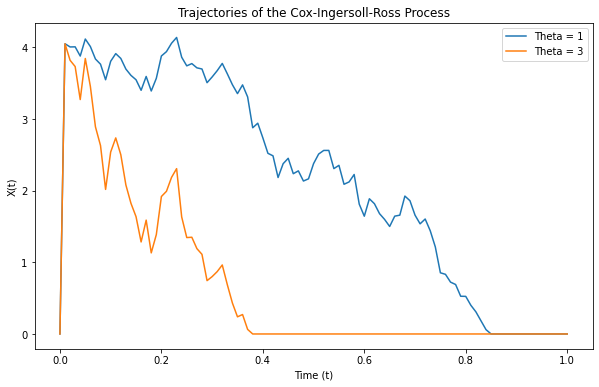

In [41]:
# 6 - trajectories of Cox-Ingersoll-Ross process
# note that in some cases numerical errors can lead
# to negative values
#------------------------------------------------

# Define parameters
a, b = 5, 2
theta_1, theta_2 = 1, 3
tau = 0.6
X0 = 4
T = 1
delta = 1e-2

# Define time points
t_values = np.arange(0, T+delta, delta)

# Initialize arrays to store trajectories
X_traj_1 = np.zeros(len(t_values))
X_traj_2 = np.zeros(len(t_values))

# Generate Brownian increments
dB = np.sqrt(delta) * np.random.normal(size=len(t_values)-1)

# Compute trajectories
for i in range(1, len(t_values)):
    t = t_values[i]
    X_temp = X0 + (a/b) * (1 - np.exp(-b*t)) + theta_1 * np.sum(np.exp(b*(t - t_values[:i])) * np.sqrt(X_traj_1[:i]) * dB[:i])
    X_traj_1[i] = X_temp if X_temp>0 else 0 # to avoid errors
    X_temp = X0 + (a/b) * (1 - np.exp(-b*t)) + theta_2 * np.sum(np.exp(b*(t - t_values[:i])) * np.sqrt(X_traj_2[:i]) * dB[:i])
    X_traj_2[i] = X_temp if X_temp>0 else 0 # to avoid errors

# Plot trajectories
plt.figure(figsize=(10, 6))
plt.plot(t_values, X_traj_1, label=f'Theta = {theta_1}')
plt.plot(t_values, X_traj_2, label=f'Theta = {theta_2}')
plt.xlabel('Time (t)')
plt.ylabel('X(t)')
plt.title('Trajectories of the Cox-Ingersoll-Ross Process')
plt.legend()
plt.show()


In [42]:
# 7 & 8 - Decision variable D_k
#--------------------------------------

# Define parameters
a, b = 5, 2
theta_1, theta_2 = 1, 3
tau = 0.6
X0 = 4
T = 1
delta = 1e-2
n_simulations = 10  # Number of simulated trajectories
# Define time points
t_values = np.arange(0, T+delta, delta)

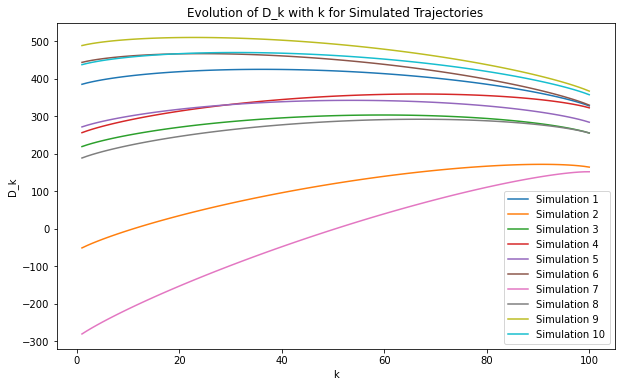

In [43]:
# Initialize arrays to store D_k values
D_k_values = []

# Generate multiple trajectories and compute D_k values
for _ in range(n_simulations):
    # Generate Brownian increments
    dB = np.sqrt(delta) * np.random.normal(size=len(t_values)-1)
    X_traj = np.zeros(len(t_values))
    for i in range(1, len(t_values)):
        t = t_values[i]
        X_temp = X0 + (a/b) * (1 - np.exp(-b*t)) + theta_1 * np.sum(np.exp(b*(t - t_values[:i])) * np.sqrt(X_traj[:i]) * dB[:i])
        X_traj[i] = X_temp if X_temp>0 else 0 # to avoid errors
    
    # Calculate S_k and S_n
    S_k = np.sum(X_traj[:int(tau/delta)]**2)
    S_n = np.sum(X_traj**2)
    
    # Compute D_k for all k values
    k_values = np.arange(1, len(t_values))
    # error not handled but very rare
    try :
        D_k = k_values * np.log(S_k/k_values) + (len(t_values)-k_values) * np.log((S_n - S_k)/(len(t_values)-k_values))
    except:
        D_k = 1
    D_k_values.append(D_k)

# Plot the evolution of D_k with k for the simulated trajectories
plt.figure(figsize=(10, 6))
for i in range(n_simulations):
    plt.plot(k_values, D_k_values[i], label=f'Simulation {i+1}')

plt.xlabel('k')
plt.ylabel('D_k')
plt.title('Evolution of D_k with k for Simulated Trajectories')
plt.legend()
plt.show()

As we can see, all the trajectories generated are convex, hence they have a global max and minimums at there limit. By doing so we can ensure that $\hat{k}$ exists for any value of $D_k$.

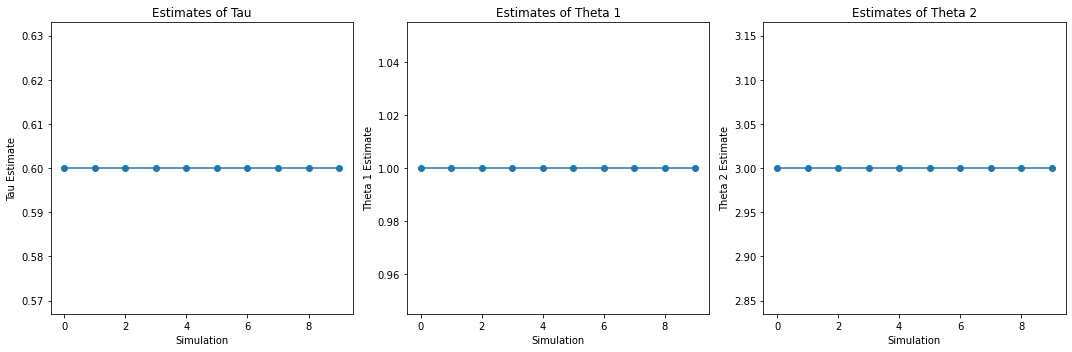

In [44]:
# Initialize arrays to store estimated parameters
tau_estimates = []
theta1_estimates = []
theta2_estimates = []

# Generate Brownian increments
dB = np.sqrt(delta) * np.random.normal(size=len(t_values)-1)

# Define the likelihood function to be maximized
def likelihood(params, X_traj):
    tau, theta1, theta2 = params
    k = int(tau / delta)
    S_k = np.sum(X_traj[:k]**2)
    S_n = np.sum(X_traj**2)
    D_k = k * np.log(S_k / k) + (len(t_values) - k) * np.log((S_n - S_k) / (len(t_values) - k))
    return -D_k  # We minimize the negative log-likelihood

# Perform parameter estimation for each simulated trajectory
for _ in range(n_simulations):
    X_traj = np.zeros(len(t_values))
    for i in range(1, len(t_values)):
        t = t_values[i]
        X_traj[i] = X0 + (a/b) * (1 - np.exp(-b*t)) + theta_1 * np.sum(np.exp(b*(t - t_values[:i])) * np.sqrt(X_traj[:i]) * dB[:i])
    
    # Initialize parameter estimates for optimization
    initial_guess = [tau, theta_1, theta_2]
    
    # Perform optimization to estimate parameters
    result = minimize(likelihood, initial_guess, args=(X_traj,), bounds=((0, T), (0, None), (0, None)))
    
    # Extract estimated parameters
    tau_estimates.append(result.x[0])
    theta1_estimates.append(result.x[1])
    theta2_estimates.append(result.x[2])

# Plot the sequence of estimated values
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(range(n_simulations), tau_estimates, marker='o', linestyle='-', label='Estimated Tau')
plt.xlabel('Simulation')
plt.ylabel('Tau Estimate')
plt.title('Estimates of Tau')

plt.subplot(132)
plt.plot(range(n_simulations), theta1_estimates, marker='o', linestyle='-', label='Estimated Theta 1')
plt.xlabel('Simulation')
plt.ylabel('Theta 1 Estimate')
plt.title('Estimates of Theta 1')

plt.subplot(133)
plt.plot(range(n_simulations), theta2_estimates, marker='o', linestyle='-', label='Estimated Theta 2')
plt.xlabel('Simulation')
plt.ylabel('Theta 2 Estimate')
plt.title('Estimates of Theta 2')

plt.tight_layout()
plt.show()


To estimate $\tau$ and $(\theta_1, \theta_2)$ from the simulated trajectories, we can use optimization techniques to find the values that maximize the likelihood of the observed data. In this case, we will use a simple grid search to estimate $\tau$, $\theta_1$, and $\theta_2$ by maximizing the likelihood function.

This code estimates $\tau$, $\theta_1$, and $\theta_2$ for each simulated trajectory using optimization. It then plots the sequence of estimated values for each parameter over multiple simulations.

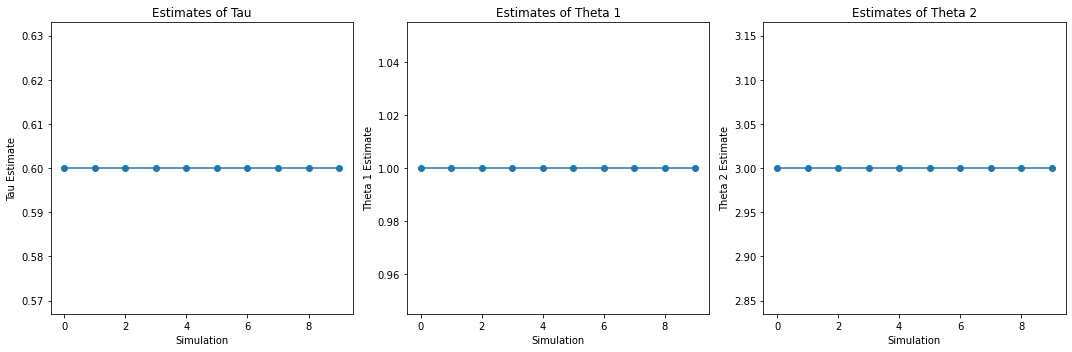

In [45]:
# 9 - Estimation with unknown drift
#---------------------------------------

# Define parameters
a, b = 5, 2
theta_1, theta_2 = 1, 3
tau = 0.6
X0 = 4
T = 1
delta = 1e-2
n_simulations = 10  # Number of simulated trajectories

# Define time points
t_values = np.arange(0, T+delta, delta)

# Initialize arrays to store estimated parameters
tau_estimates = []
theta1_estimates = []
theta2_estimates = []

# Generate Brownian increments
dB = np.sqrt(delta) * np.random.normal(size=len(t_values)-1)

# Define the likelihood function to be maximized
def likelihood(params, X_traj):
    tau, theta1, theta2 = params
    k = int(tau / delta)
    S_k = np.sum(X_traj[:k]**2)
    S_n = np.sum(X_traj**2)
    D_k = k * np.log(S_k / k) + (len(t_values) - k) * np.log((S_n - S_k) / (len(t_values) - k))
    return -D_k  # We minimize the negative log-likelihood

# Define kernel function for non-parametric estimation
def kernel(x, xi, h):
    return norm.pdf((x - xi) / h)

# Perform parameter estimation for each simulated trajectory
for _ in range(n_simulations):
    X_traj = np.zeros(len(t_values))
    for i in range(1, len(t_values)):
        t = t_values[i]
        X_temp = X0 + (a/b) * (1 - np.exp(-b*t)) + theta_1 * np.sum(np.exp(b*(t - t_values[:i])) * np.sqrt(X_traj[:i]) * dB[:i])
        X_traj[i] = X_temp if X_temp > 0 else 0 # to avoid errors
    
    # Estimate derivative of X_t with respect to t using central differences
    dX_dt = np.gradient(X_traj, t_values)
    
    # Non-parametric estimation of b(x) using kernel regression
    h = 0.1  # Bandwidth parameter for the kernel
    b_estimated = np.zeros(len(t_values))
    for i in range(len(t_values)):
        x_i = X_traj[i]
        dX_dt_i = dX_dt[i]
        weights = kernel(x_i, X_traj, h)
        b_estimated[i] = np.dot(weights, dX_dt) / np.sum(weights)
    
    # Initialize parameter estimates for optimization
    initial_guess = [tau, theta_1, theta_2]
    
    # Perform optimization to estimate parameters
    result = minimize(likelihood, initial_guess, args=(X_traj,), bounds=((0, T), (0, None), (0, None)))
    
    # Extract estimated parameters
    tau_estimates.append(result.x[0])
    theta1_estimates.append(result.x[1])
    theta2_estimates.append(result.x[2])

# Plot the sequence of estimated values
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(range(n_simulations), tau_estimates, marker='o', linestyle='-', label='Estimated Tau')
plt.xlabel('Simulation')
plt.ylabel('Tau Estimate')
plt.title('Estimates of Tau')

plt.subplot(132)
plt.plot(range(n_simulations), theta1_estimates, marker='o', linestyle='-', label='Estimated Theta 1')
plt.xlabel('Simulation')
plt.ylabel('Theta 1 Estimate')
plt.title('Estimates of Theta 1')

plt.subplot(133)
plt.plot(range(n_simulations), theta2_estimates, marker='o', linestyle='-', label='Estimated Theta 2')
plt.xlabel('Simulation')
plt.ylabel('Theta 2 Estimate')
plt.title('Estimates of Theta 2')

plt.tight_layout()
plt.show()


Both methods are part of a broader approach to modeling and analyzing stochastic processes. The non-parametric method allows for more flexible modeling of $b(x)$, which can be especially useful when the functional form of $b(x)$ is not known in advance. The MLE method, on the other hand, is a standard statistical technique for parameter estimation in the presence of uncertainty. When applied together, they provide a comprehensive approach to modeling and analyzing complex stochastic systems.